In [15]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()">expand</a>.''')

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [17]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

#                                  Presentation Data Exploration

In [18]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   \
          'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns
timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
panel = panel.loc[:,selected]

 
 
 

In [19]:
city_name = 'sj'
def get_data_panel(panel,city_name):
    panel_train =  panel.loc[panel.city == city_name].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1).copy()
    
    panel_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
    panel_test['total_cases'] = np.nan 
    train_len = len(panel_test['total_cases'])
    panel = pd.concat([panel_train,panel_test],sort = False)
    
    
    panel['green_s']  = panel.loc[:,green[:2]].mean(1)
    panel['green_n']  = panel.loc[:,green[2:]].mean(1) 
    panel['green']  = panel.loc[:,green ].mean(1) 

    panel  = panel 
    return panel,train_len

panel_sj,len_sj = get_data_panel(panel,'sj')
panel_iq,len_iq = get_data_panel(panel,'iq')

def min_max(data):
     
    return (data - data.min())/(data .max()- data.min())
    

## Discribe data
 
#### 1. Target: reported total cases  Dengue fever cases weekly
#### 2. Features:
    1. Weekly Climate / environment data for San Juan(SJ) and Iquitos(IQ)
    2. Data can be catigorized by temperature(min/max/average), humidity,temperature range, precipitation
      and vagitation
    3. There are two schools (reanalysis(Theory recalculated) and measurement) for one climate variable.They are similar some even 
      duplicated. 
#### 3. dataset:
    1. For SJ, Train/Test(for submission) size is 936/260.(1990/04/30 - 2008/04/22 and 2008/04/29 - 2013/04/23) 
    2. For IQ, Train/Test(for submission) size is 520/156.(2000/07/01 - 2010/06/25 and 2010/07/02 - 2013/06/25)
    4. Missing values:not too much missing value over all except ndvi_ne and ndvi_sw.

## Explore data

### Targets

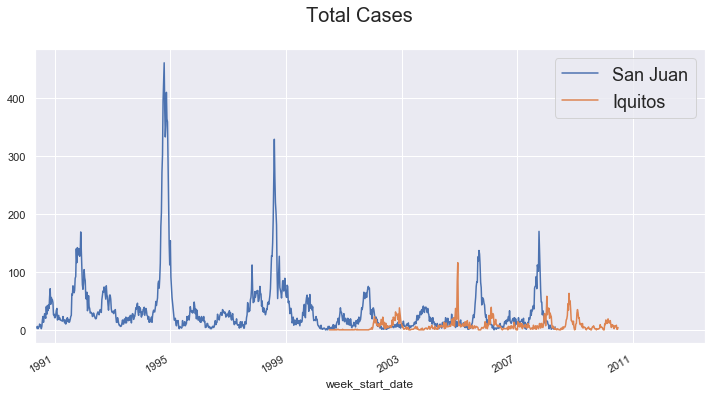

In [20]:
 
fig = plt.figure(figsize = (12,6) )
fig.suptitle('Total Cases', fontsize=20)
panel_sj.total_cases .plot( )
panel_iq .total_cases .plot()
plt.legend(['San Juan','Iquitos'],fontsize = 18)


### Targets(Cont.):
    1. They are differed in scale and have some overlapping in time 
    2. First 60 data for IQ are 0, it is considered very from other observations
    3. The plots show strong seasonality. Peaks are much higher than usual values.-  detrend/deseason might need to be done
    4. For long term trend: SJ is decrease in scale while IQ is incrasing. This might relate to population informations
    
    
    

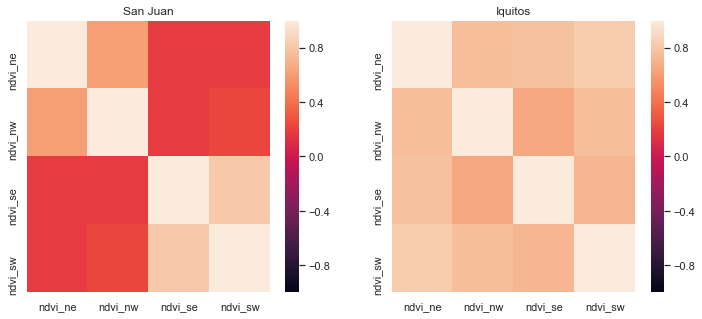

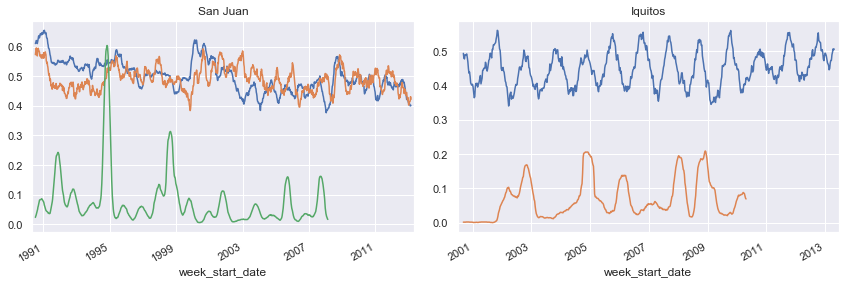

In [21]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,green[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
min_max(panel_sj).loc[:,green[2: ]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,green].mean(1).rolling(20,center = True) .mean()  .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Vagitation:
    1. For SJ vagitation in the south are similar. while for IQ they are highly correlated, in this case I will take avarge of them 
      to reduce dimentions
    2. IQ's ndvi shows seasonality correspinding to the seasonality of total cases. Though higher peak doesn't indicate an out        break
    

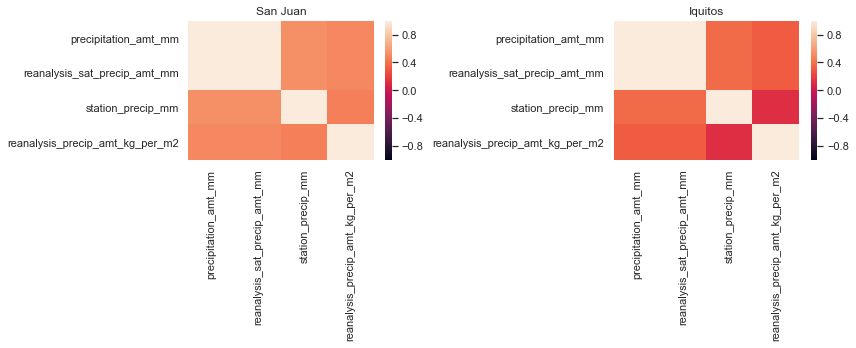

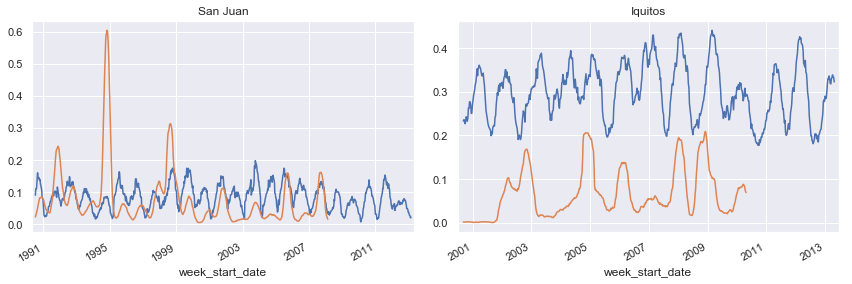

In [22]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### precipitation
    1. The seasonality of precipitation actually predict quite well that of total cases'.  
    2. There is counter example in 1995 for San Juan, using this sample may produce negtive impack, should we remove this time period?
   

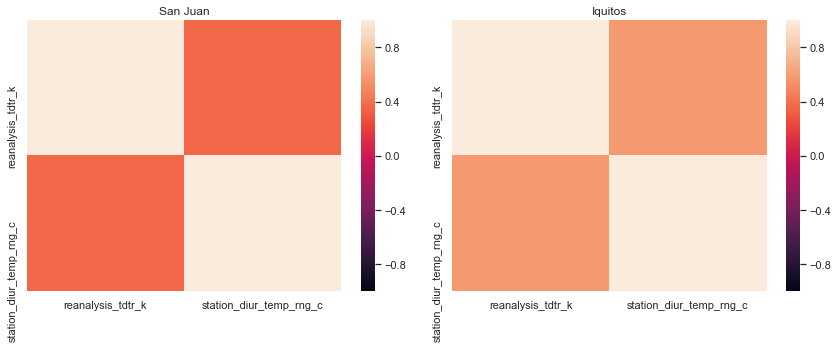

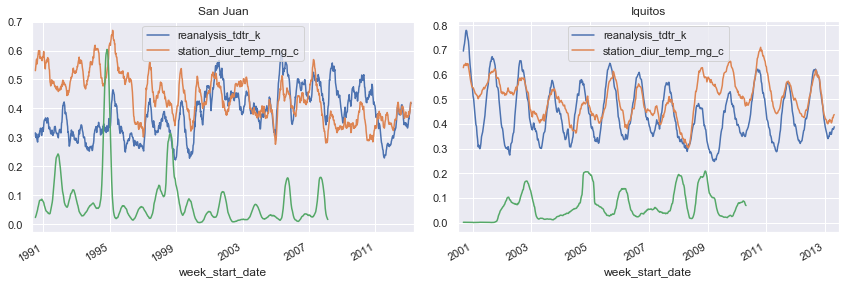

In [23]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

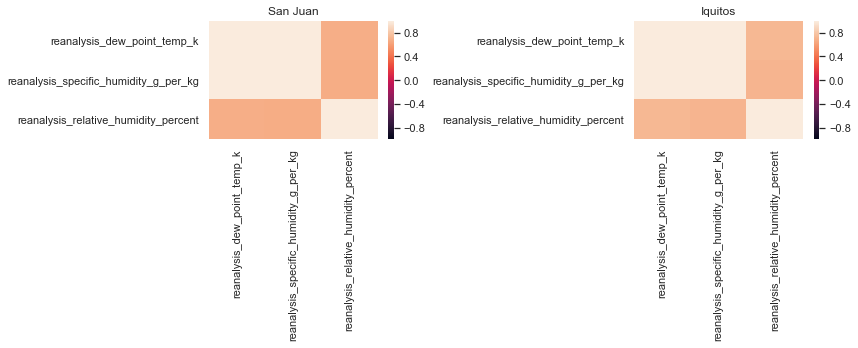

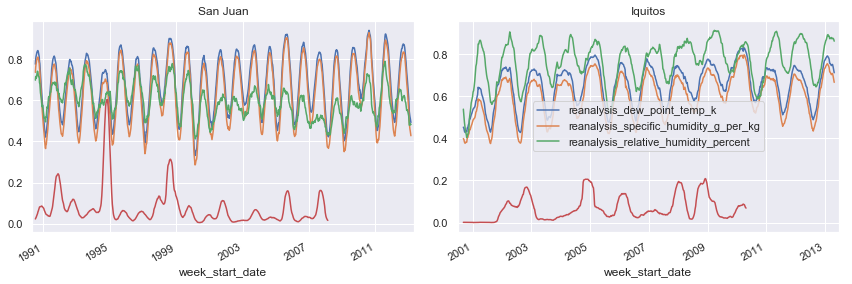

In [24]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()



"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[0],legend = False)
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0],legend = False)




min_max(panel_iq).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Humidity: Specific humidity and dew point temperature are almost the same

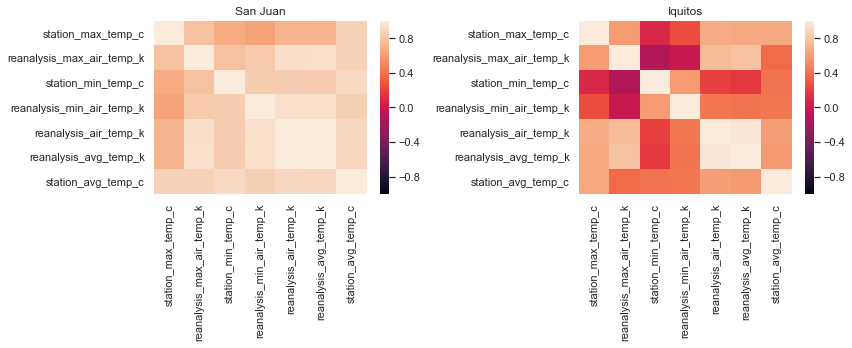

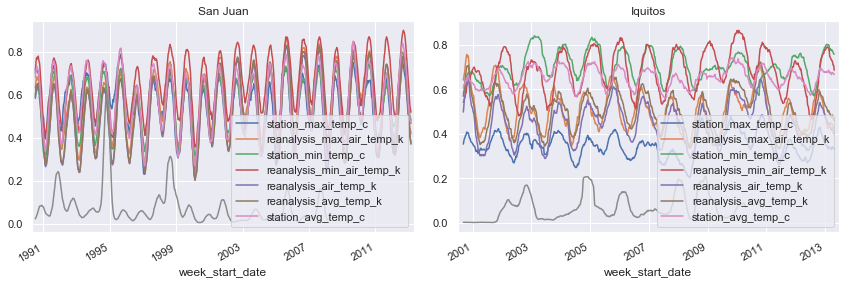

In [25]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Strong seasonality in temperature


 


### Some thoughts
    1. There is not any apparent linear realationship between factor and total cases beside from seasonality. We might need to   consider some non-linear family(NN/Tree) or some ensamble methods
    2. Given the comlexity of trend/seasonality/ jumps, smoothing/de-season/take diffrence will provide a better look
    3. Each observation is highly depends on the previos one. But in the testing set, we don't have passed observations. LSTM seems to adress this issure but passing the memories. It will be an interesting teritory to be explored
    4. Patten of SJ and IQ are quiet different(Different trend, seasonality, peaks)
    

# Features vs Target

## Given the seasonality, it is hard to indentify "real correlation"
I will de-season and calculate correlation then

In [26]:
series = panel_sj.loc[:,'total_cases']
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.1),train_y.quantile(0.9))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1

panel_sj_ds = panel_sj.apply(de_season_tri,axis = 0)
panel_iq_ds = panel_iq.apply(de_season_tri,axis = 0)

D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


##  After de-seasoning, there seems to be some patterns

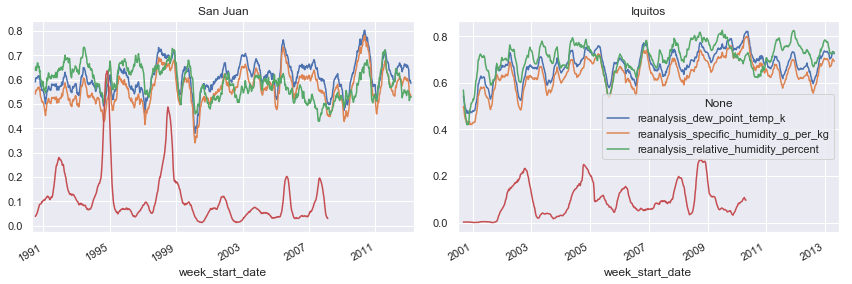

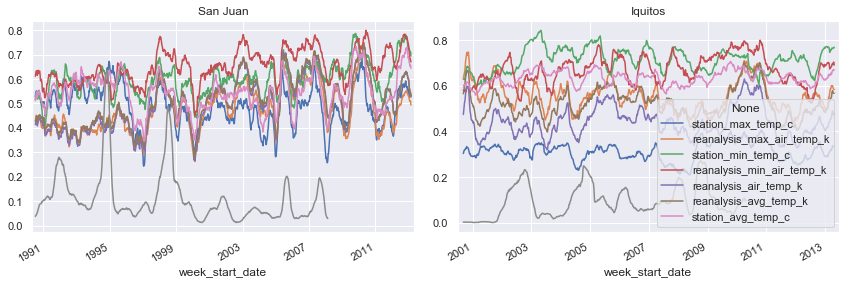

In [40]:
"""
See how it goes after de-season
max_temp + min_temp + avg_temp 
humid
green
precipitation
dtr
"""
from matplotlib.font_manager import FontProperties
 
 


selected_features = humid
f, axes = plt.subplots(1, 2,figsize = (12,4) )
 
min_max(panel_sj_ds).loc[:,selected_features ] .rolling(20,center = True).mean()  .plot(ax =axes[0], legend=False ) 

cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .rolling(20,center = True).mean()  .plot(ax =axes[1] )
plt.legend(loc='best')
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')



selected_features = max_temp + min_temp + avg_temp 
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj_ds).loc[:,selected_features ] .rolling(20,center = True).mean()  .plot(ax =axes[0], legend=False) 
 
cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .rolling(20,center = True).mean()  .plot(ax =axes[1], legend=False)
 
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
plt.legend(loc='best') 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

## Build Models

## Brute Force Feature selection: Random Forest

In [108]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

drops = ['reanalysis_specific_humidity_g_per_kg']  + green +\
['reanalysis_sat_precip_amt_mm','reanalysis_avg_temp_k','year','weekofyear','total_cases'] 
 
panel_sj_selected  = panel_sj.loc[:,['total_cases']]
panel_iq_selected  = panel_iq.loc[:,['total_cases']] 

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().diff(diff).loc[:,name ]
    return left


def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(0,x.quantile(0.9)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth    ).mean().diff(diff).loc[:,name ]
    return left



def data_process(panel,panel_candidate ):
    
    """
    Make sure it is at least forward filled
    """
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,52)
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,20)
    
    panel = append_diff(panel,panel_candidate,\
          panel_candidate.columns,52,20)
    
    
    # de - seasons
    de_seasons = panel_candidate.apply(de_season_tri,axis = 0)
    new_names = [name +'_ds' for name in de_seasons.columns]
    de_seasons.columns = new_names
    
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,52)
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,20)
    
    panel = append_diff(panel,de_seasons,\
          de_seasons.columns,26,20)
    
    
    
 
 
    
    return panel 



panel_sj_selected =  data_process(panel_sj_selected,panel_sj.drop(drops,axis = 1))
panel_iq_selected =  data_process(panel_iq_selected,panel_iq.drop(drops,axis = 1)) 


train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                            panel_sj_selected .iloc[: -len_sj] .dropna().drop('total_cases',axis = 1)  
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                            panel_iq_selected.iloc[60: -len_iq] .dropna() .drop('total_cases',axis = 1)  
                         

test_X_sj = panel_sj_selected.drop('total_cases',axis = 1)  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.drop('total_cases',axis = 1)  .iloc[-len_iq: ]





### Random Forest(Parameters are picked after grid-search and cross validation)

In [46]:
rf_sj = RandomForestRegressor(n_estimators=400,  
                                         max_depth=6, criterion='mae',  max_features='auto', warm_start=True, \
                                )
rf_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )
rf_iq = RandomForestRegressor(n_estimators=400, max_features='auto',
                                         max_depth=6, criterion='mae',  warm_start=True)

rf_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(rf_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(rf_iq .predict(test_X_iq )).astype(int) ) 

###  Feature importances for SJ(Top 50)

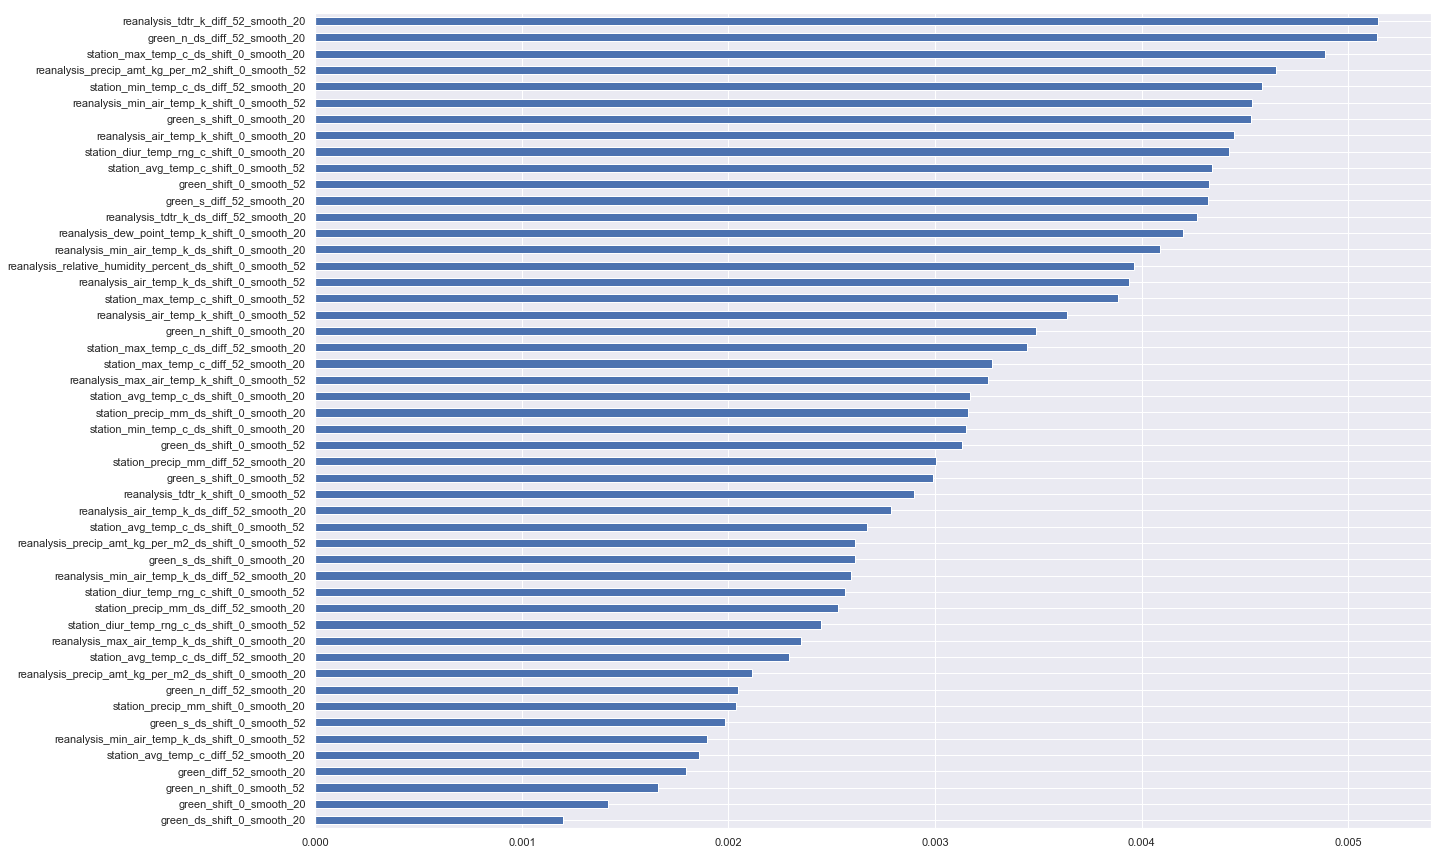

In [16]:
plt.figure(figsize = (20,15))
pd.Series(mdl_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50].plot.barh()

###  Feature importances for IQ (Top 50)

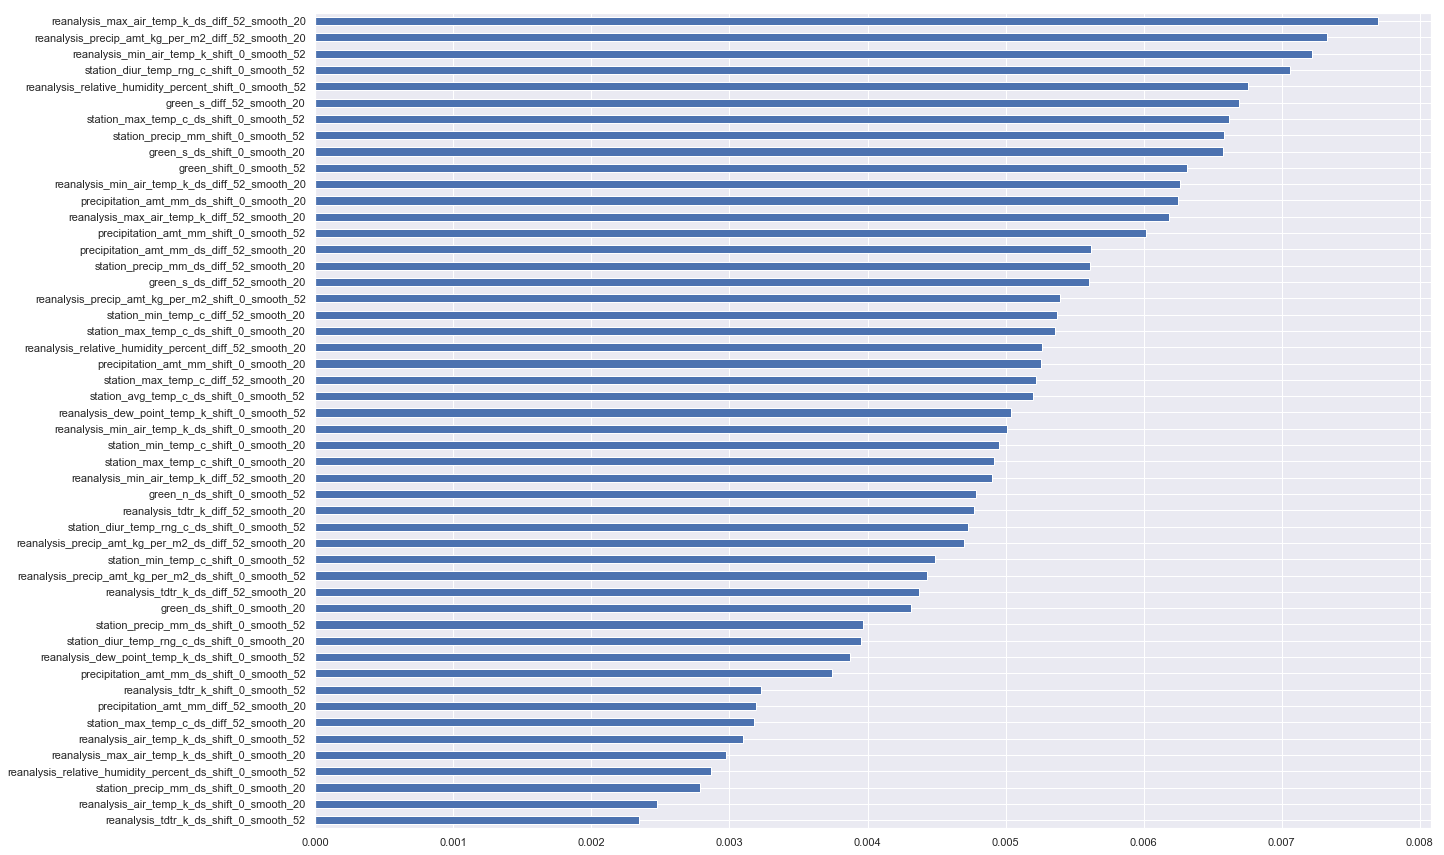

In [17]:
plt.figure(figsize = (20,15))
pd.Series(mdl_iq.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:50].plot.barh()

## XGBoost

D:\Anaconda3\envs\interview_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


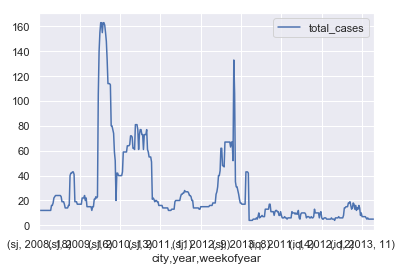

In [44]:
from xgboost import XGBRegressor
 
 
 
xgb_sj = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


xgb_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )


xgb_iq = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

xgb_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(xgb_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(xgb_iq .predict(test_X_iq )).astype(int) ) 

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_xgb.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

### Selecting features then Use GLM

In [112]:
rf_importance_sj = pd.Series(rf_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:30]
xgb_importance_sj = pd.Series(xgb_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:30]
selected = xgb_importance_sj .index.intersection(rf_importance_sj .index)
selected_sj =selected 
rf_importance_iq = pd.Series(rf_iq.feature_importances_,index = train_X_iq.columns).sort_values(ascending = True).iloc[:30]
xgb_importance_iq = pd.Series(xgb_iq.feature_importances_,index = train_X_iq.columns).sort_values(ascending = True).iloc[:30]

selected_iq =   xgb_importance_iq .index.intersection(rf_importance_iq .index)

 

In [113]:
selected_iq

Index(['green_ds_diff_26_smooth_20',
       'reanalysis_precip_amt_kg_per_m2_ds_shift_0_smooth_20',
       'station_precip_mm_ds_shift_0_smooth_20',
       'reanalysis_min_air_temp_k_diff_52_smooth_20',
       'precipitation_amt_mm_ds_shift_0_smooth_20',
       'reanalysis_air_temp_k_ds_shift_0_smooth_20',
       'reanalysis_dew_point_temp_k_ds_shift_0_smooth_52',
       'reanalysis_relative_humidity_percent_ds_shift_0_smooth_52',
       'reanalysis_tdtr_k_ds_shift_0_smooth_52',
       'station_max_temp_c_ds_shift_0_smooth_52',
       'station_min_temp_c_ds_shift_0_smooth_52',
       'reanalysis_air_temp_k_ds_shift_0_smooth_52',
       'station_avg_temp_c_ds_shift_0_smooth_52',
       'precipitation_amt_mm_ds_shift_0_smooth_52',
       'station_precip_mm_ds_shift_0_smooth_52',
       'reanalysis_precip_amt_kg_per_m2_ds_shift_0_smooth_52'],
      dtype='object')

In [99]:
import statsmodels.api as sm
def normalize(df, how ):
    if how == 'z':
        return (df - df.mean())/(df.std())
    if how == 'r':
        return (df - df.min())/(df.max() - df.min())
    
    
    
train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                             normalize(panel_sj_selected,'r' ).iloc[: -len_sj] .dropna().loc[:,selected_sj ] 
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                             normalize(panel_iq_selected,'r').iloc[60: -len_iq] .dropna().loc[:,selected_iq ] 
                         
train_X_sj  = sm.add_constant(train_X_sj )
train_X_iq  = sm.add_constant(train_X_iq )


test_X_sj = panel_sj_selected.loc[:,selected_sj  ]  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.loc[:,selected_iq   ]  .iloc[-len_iq: ]


test_X_sj  = sm.add_constant(test_X_sj )
test_X_iq  = sm.add_constant(test_X_iq )

In [81]:
train_X_sj .shape

(865, 8)

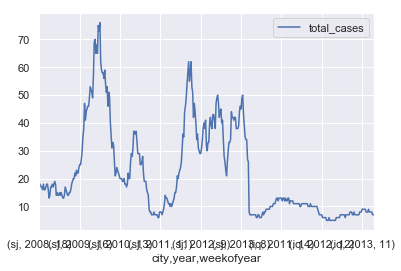

In [124]:
glm_sj = XGBRegressor(base_score=0.5, booster='gblinear' ,\
               learning_rate=0.02, 
                  
               reg_lambda=2,
               objective='count:poisson' , scale_pos_weight=1)


glm_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )


glm_iq = XGBRegressor(   booster='gblinear' ,\
            learning_rate=0.02,  
            
             n_jobs=4, nthread=None, objective='count:poisson',
            reg_lambda=2 )

glm_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(glm_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(glm_iq .predict(test_X_iq )).astype(int) ) 

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_glm.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

In [55]:
train_y_sj.clip(0,250)

week_start_date
1991-09-10     68.0
1991-09-17     89.0
1991-09-24     92.0
1991-10-01    140.0
1991-10-08    116.0
1991-10-15    142.0
1991-10-22    129.0
1991-10-29    140.0
1991-11-05    140.0
1991-11-12    127.0
1991-11-19    129.0
1991-11-26    169.0
1991-12-03    141.0
1991-12-10    108.0
1991-12-17     78.0
1991-12-24     70.0
1992-01-01     81.0
1992-01-08    104.0
1992-01-15     90.0
1992-01-22     85.0
1992-01-29     55.0
1992-02-05     53.0
1992-02-12     65.0
1992-02-19     33.0
1992-02-26     38.0
1992-03-04     59.0
1992-03-11     40.0
1992-03-18     37.0
1992-03-25     29.0
1992-04-01     30.0
1992-04-08     30.0
1992-04-15     28.0
1992-04-22     23.0
1992-04-29     24.0
1992-05-06     29.0
1992-05-13     26.0
1992-05-20     23.0
1992-05-27     20.0
1992-06-03     19.0
1992-06-10     20.0
1992-06-17     26.0
1992-06-24     29.0
1992-07-01     31.0
1992-07-08     28.0
1992-07-15     26.0
1992-07-22     32.0
1992-07-29     35.0
1992-08-05     33.0
1992-08-12     30.0
1992